# Gaussian Process Regression Prediction Based on Unified Relative Sampling Points

## 1. Import Libraries

In [1]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import mean_squared_error
from scipy.optimize import dual_annealing
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import glob
import warnings
from sklearn.exceptions import ConvergenceWarning

# Set random seed for reproducibility
np.random.seed(123)

warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Set matplotlib style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Create directory to save results
results_dir = './unified_sampling_results'
os.makedirs(results_dir, exist_ok=True)

## 2. Data Loading and Preprocessing

In this section, we will load hardness distribution data from multiple plates from Excel files, handle potential missing values and outliers, and standardize the data for model training and evaluation.

In [2]:
def hardness_transformation(H):
    """
    Calculate the transformed hardness value delta based on the formula.
    
    Args:
        H: Hardness value (float or ndarray)
        
    Returns:
        delta: Transformed value
    """
    delta = 0.67 * np.exp(-H / 0.11) - 1.49e-5 * np.exp(H / 0.10) + 0.33
    return delta

# Define a function to load plate hardness distribution data from Excel files
def load_plate_data(file_path):
    """
    Load hardness distribution data in tabular format from an Excel file.
    
    Args:
        file_path: Path to the Excel file
        
    Returns:
        A dictionary containing the processed data for all sheets.
    """
    sheet_names = ['sp-1', 'sp-2', 'sp-3', 'sp-4']
    all_plates_data = {}
    
    for sheet_name in sheet_names:
        try:
            # Read the original Excel sheet
            df = pd.read_excel(file_path, sheet_name=sheet_name, header=None)
            
            # The first row contains X coordinates, and the first column contains Y coordinates
            try:
                x_coords = pd.to_numeric(df.iloc[0, 1:].dropna(), errors='coerce').dropna().values  
                y_coords = pd.to_numeric(df.iloc[1:, 0].dropna(), errors='coerce').dropna().values
            except Exception as e:
                print(f"Error converting coordinates to numeric in sheet {sheet_name}: {e}")
                continue
                
            # Initialize lists to store point data
            points = []
            values = []
            x_points = []
            y_points = []
            
            # Iterate through the table to extract non-empty hardness values
            for i in range(1, df.shape[0]):
                for j in range(1, df.shape[1]):
                    if pd.notna(df.iloc[i, j]) and pd.notna(df.iloc[i, 0]) and pd.notna(df.iloc[0, j]):
                        try:
                            # Ensure all data is converted to float
                            y = float(df.iloc[i, 0])  # Y coordinate from the first column
                            x = float(df.iloc[0, j])  # X coordinate from the first row
                            value = hardness_transformation(float(df.iloc[i, j]) / 100)  # Depth value
                            
                            x_points.append(x)
                            y_points.append(y)
                            points.append([x, y])
                            values.append(value)
                        except (ValueError, TypeError):
                            # Skip cells that cannot be converted to numeric values
                            continue
            
            if not points:  # If no valid points are found
                print(f"No valid data points found in sheet {sheet_name}")
                continue
                
            # Convert to NumPy arrays
            points = np.array(points)
            values = np.array(values)
            x_points = np.array(x_points)
            y_points = np.array(y_points)
            
            # Normalize values
            value_min = np.min(values)
            value_max = np.max(values)
            value_normalized = (values - value_min) / (value_max - value_min)
            
            all_plates_data[sheet_name] = {
                'df': df,  # Original dataframe
                'x': x_points,
                'y': y_points,
                'value': values,
                'value_min': value_min,
                'value_max': value_max,
                'value_normalized': value_normalized,
                'points': points,
                'name': sheet_name
            }
            
            print(f"Successfully loaded {sheet_name} with {len(values)} data points")
            
        except Exception as e:
            print(f"Error loading sheet {sheet_name} from {os.path.basename(file_path)}: {e}")
    
    return all_plates_data

# Load all plate data files
data_folder = "./data/"
plate_files = glob.glob(os.path.join(data_folder, "*.xlsx"))

print(f"Found {len(plate_files)} plate data files:")
for file in plate_files:
    print(f"  - {os.path.basename(file)}")

# Load and process all plate data
plates_data = {}
for file_path in plate_files:
    file_plates = load_plate_data(file_path)
    # Add all sheets from this file to the plates_data dictionary
    plates_data.update(file_plates)

plate_name_mapping = {
    'sp-1': 'Specimen-1',
    'sp-2': 'Specimen-2',
    'sp-3': 'Specimen-3',
    'sp-4': 'Specimen-4'
}

# Print a summary of the loaded data
print(f"\nLoaded {len(plates_data)} plates in total:")
for plate_name, plate_data in plates_data.items():
    display_name = plate_name_mapping.get(plate_name, plate_name)
    print(f"\nPlate: {display_name}")
    print(f"  Data points: {len(plate_data['value'])}")
    print(f"  Value range: {plate_data['value_min']:.2f} to {plate_data['value_max']:.2f}")
    print(f"  Average value: {np.mean(plate_data['value']):.2f}")
    print(f"  X range: {np.min(plate_data['x']):.1f} to {np.max(plate_data['x']):.1f}")
    print(f"  Y range: {np.min(plate_data['y']):.1f} to {np.max(plate_data['y']):.1f}")

Found 1 plate data files:
  - datas.xlsx
Successfully loaded sp-1 with 359 data points
Successfully loaded sp-2 with 132 data points
Successfully loaded sp-3 with 323 data points
Successfully loaded sp-4 with 312 data points

Loaded 4 plates in total:

Plate: Specimen-1
  Data points: 359
  Value range: 0.07 to 0.34
  Average value: 0.21
  X range: -75.0 to 75.0
  Y range: -40.0 to 40.0

Plate: Specimen-2
  Data points: 132
  Value range: 0.07 to 0.32
  Average value: 0.20
  X range: -30.0 to 25.0
  Y range: -25.0 to 25.0

Plate: Specimen-3
  Data points: 323
  Value range: 0.06 to 0.34
  Average value: 0.18
  X range: -65.0 to 65.0
  Y range: -45.0 to 50.0

Plate: Specimen-4
  Data points: 312
  Value range: 0.10 to 0.37
  Average value: 0.23
  X range: -65.0 to 65.0
  Y range: -40.0 to 45.0


## 3. Visualize Original Data Distribution

Visualization charts, including scatter plots, 3D surface plots, and heatmaps.


Visualizing Specimen-1:


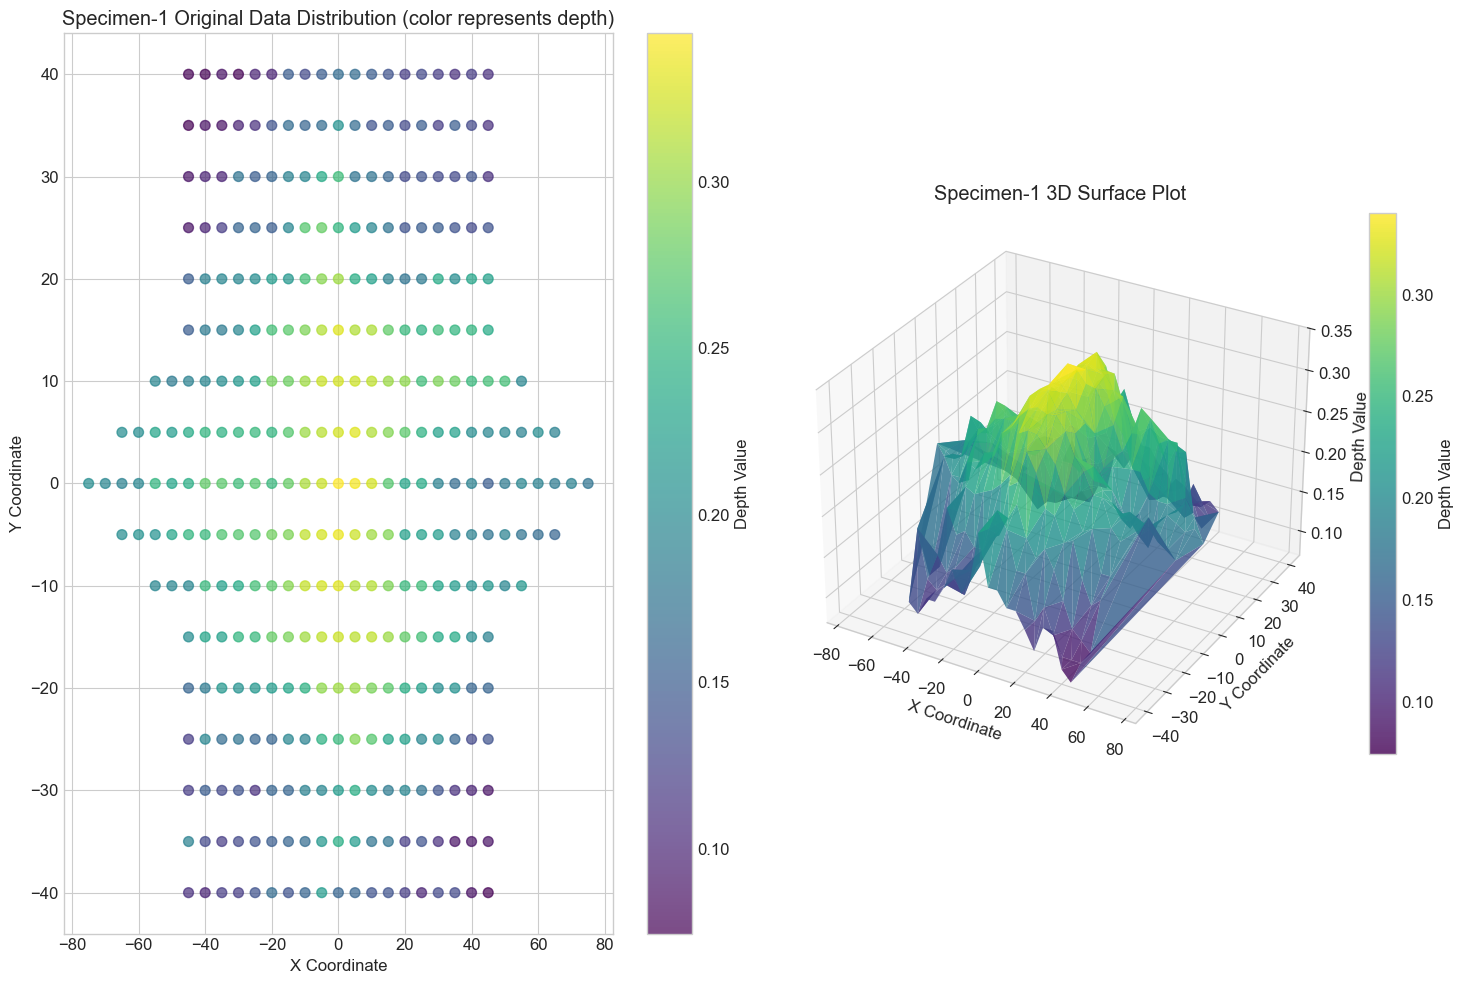


Visualizing Specimen-2:


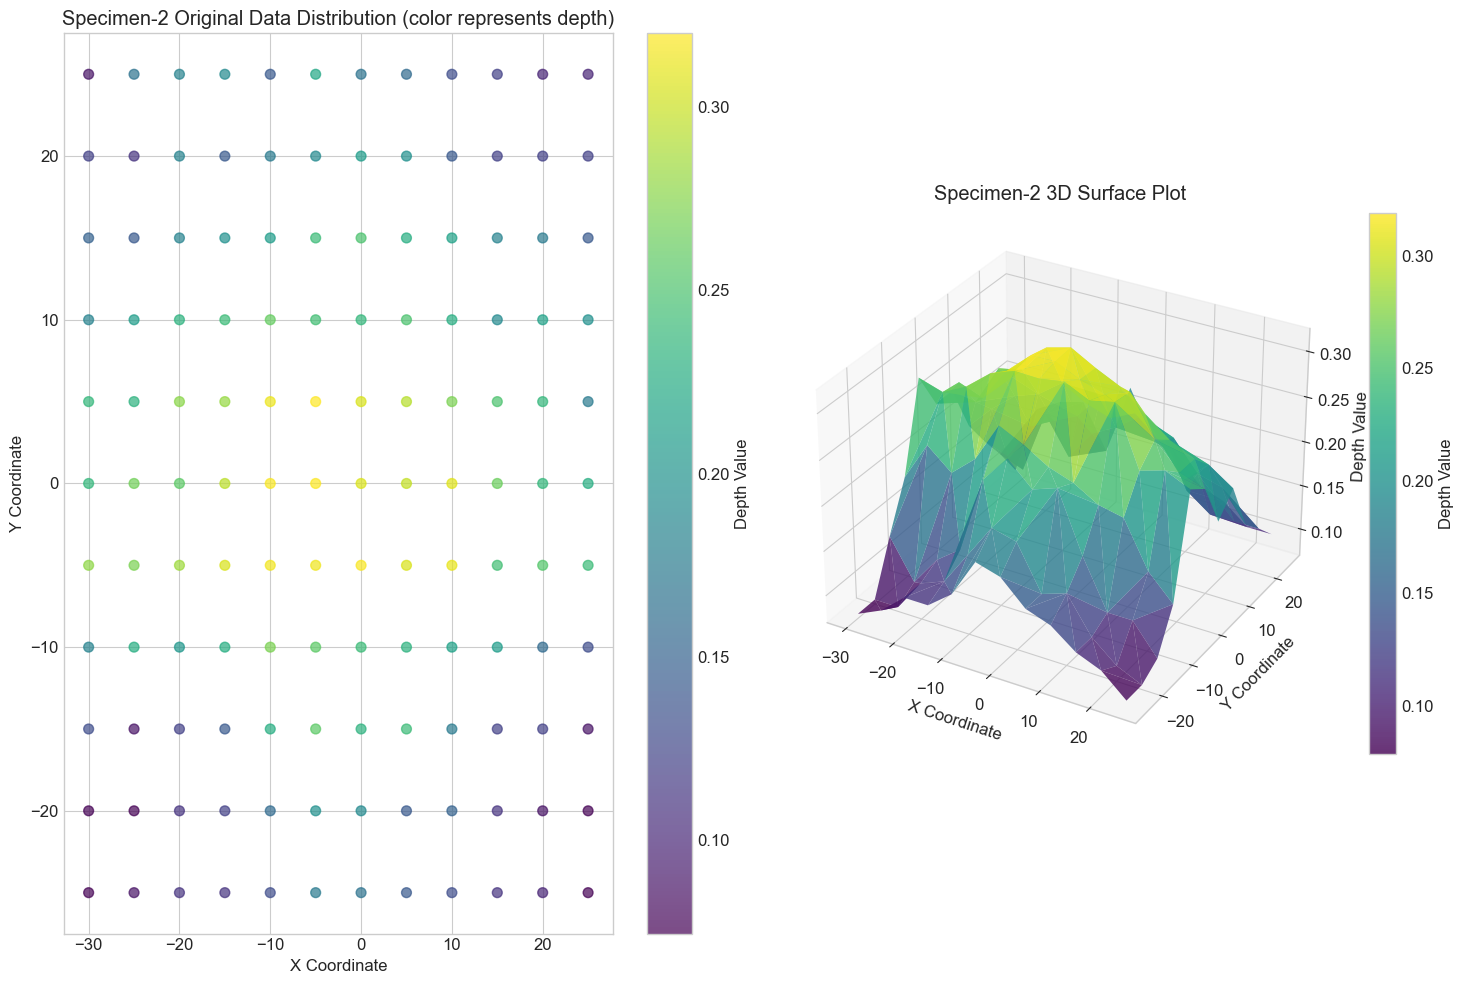


Visualizing Specimen-3:


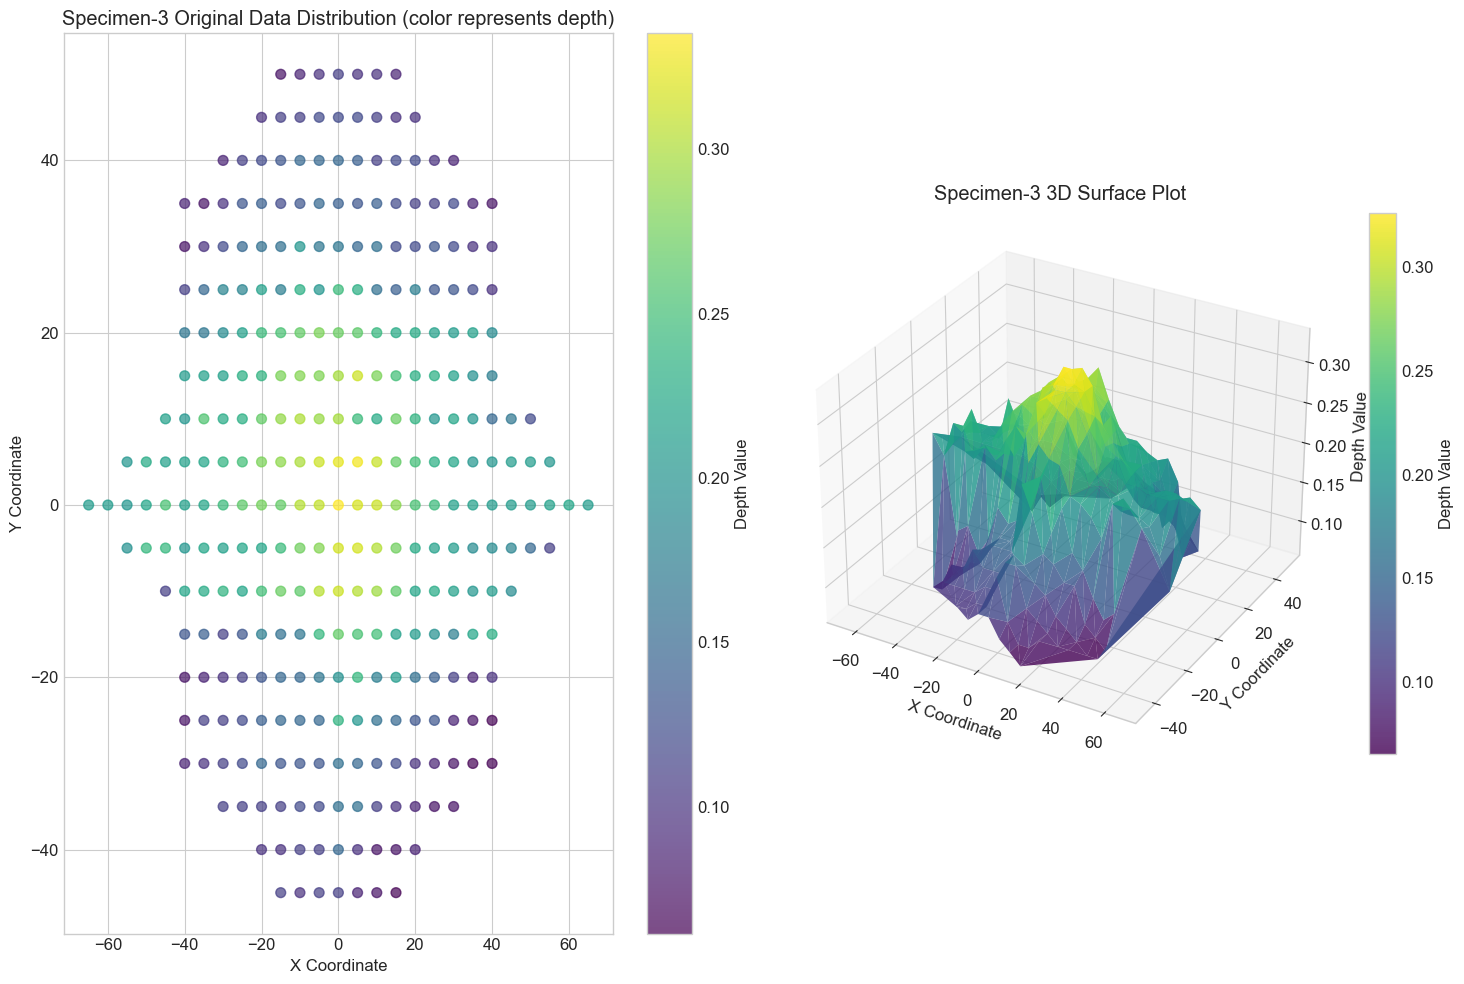


Visualizing Specimen-4:


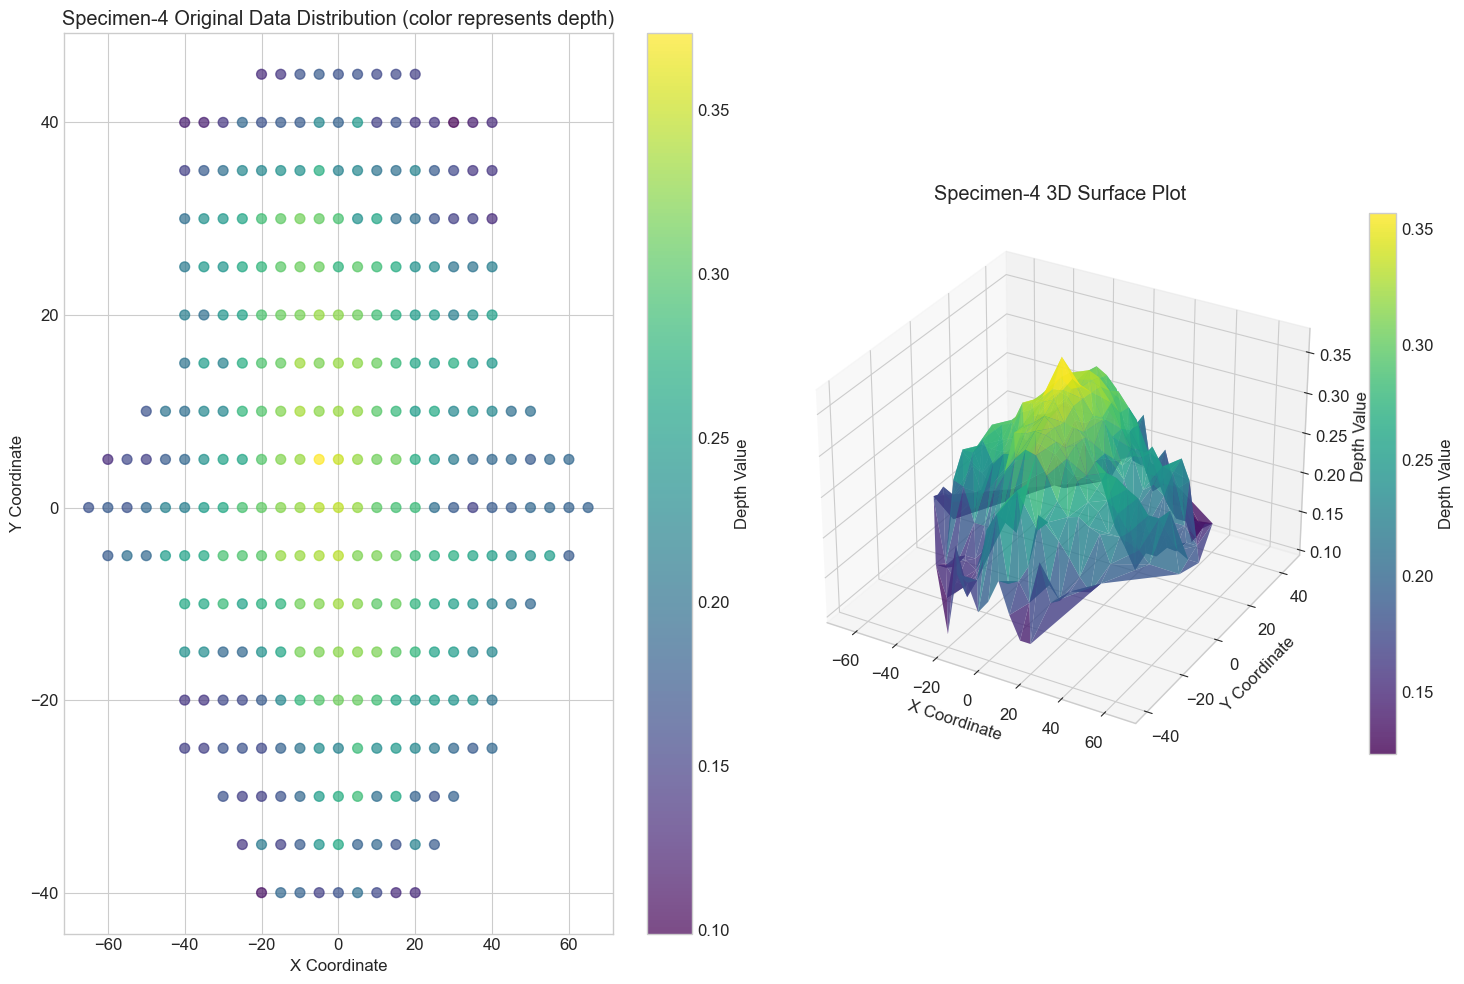

In [3]:
# Visualization function for plate data distribution
def visualize_plate_data(plate_data):
    """
    Create comprehensive visualizations for plate data
    """
    original_name = plate_data['name']
    plate_name = plate_name_mapping.get(original_name, original_name)
    x = plate_data['x']
    y = plate_data['y']
    value = plate_data['value']
    
    fig = plt.figure(figsize=(15, 10))
    
    # 1. 2D scatter plot, color represents Depth value
    ax1 = fig.add_subplot(121)
    scatter = ax1.scatter(x, y, c=value, cmap='viridis', s=50, alpha=0.7)
    ax1.set_xlabel('X Coordinate')
    ax1.set_ylabel('Y Coordinate')
    ax1.set_title(f'{plate_name} Original Data Distribution (color represents depth)')
    ax1.grid(True)
    plt.colorbar(scatter, ax=ax1, label='Depth Value')
    
    # 2. 3D surface plot
    ax2 = fig.add_subplot(122, projection='3d')
    surf = ax2.plot_trisurf(x, y, value, cmap='viridis', edgecolor='none', alpha=0.8)
    ax2.set_xlabel('X Coordinate')
    ax2.set_ylabel('Y Coordinate')
    ax2.set_zlabel('Depth Value')
    ax2.set_title(f'{plate_name} 3D Surface Plot')
    plt.colorbar(surf, ax=ax2, shrink=0.6, aspect=20, label='Depth Value')
    
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, f'{plate_name}_original_distribution.png'), dpi=300)
    plt.show()

# Create visualizations for each plate
for plate_name, plate_data in plates_data.items():
    display_name = plate_name_mapping.get(plate_name, plate_name)
    print(f"\nVisualizing {display_name}:")
    visualize_plate_data(plate_data)

## 4. Gaussian Process Regression Model Design

Gaussian Process Regression (GPR) is a non-parametric Bayesian method used to define a prior distribution over functions. The basic formula for GPR is:

$$f(x) \sim \mathcal{GP}(m(x), k(x, x'))$$

Where:
- $m(x)$ is the mean function, representing the prior expectation.
- $k(x, x')$ is the covariance function (kernel function), representing the correlation between any two points.

We will use the Radial Basis Function (RBF) kernel, mathematically expressed as:

$$k(x_i, x_j) = \sigma_f^2 \exp\left(-\frac{||x_i - x_j||^2}{2l^2}\right)$$

where $\sigma_f^2$ is the signal variance and $l$ is the length scale parameter.

In [4]:
# Define GPR model class
class GPRModel:
    def __init__(self, kernel=None, alpha=1e-2, n_restarts_optimizer=10):
        """
        Initialize GPR model

        Args:
            kernel: Kernel function, default is RBF
            alpha: Noise level for numerical stability
            n_restarts_optimizer: Number of restarts for hyperparameter optimization
        """
        if kernel is None:
            # Use RBF kernel by default, set length scale bounds
            self.kernel = 1.0 * RBF(length_scale=40.0, length_scale_bounds=(1e-2, 1e3))
        else:
            self.kernel = kernel

        self.model = GaussianProcessRegressor(
            kernel=self.kernel,
            alpha=alpha,
            n_restarts_optimizer=n_restarts_optimizer,
            random_state=123
        )

    def fit(self, X_train, y_train):
        """Train the model"""
        self.model.fit(X_train, y_train)
        return self

    def predict(self, X_test, return_std=False):
        """Make predictions"""
        return self.model.predict(X_test, return_std=return_std)

    def score(self, X_test, y_test):
        """Calculate R^2 score"""
        return self.model.score(X_test, y_test)

    def get_kernel_params(self):
        """Get optimized kernel parameters"""
        return self.model.kernel_

    def get_log_marginal_likelihood(self):
        """Get log marginal likelihood"""
        return self.model.log_marginal_likelihood()

# Test different kernels
def test_different_kernels(X_train, y_train, X_test, y_test):
    """Test the performance of different kernel functions"""
    kernels = {
        'RBF': 1.0 * RBF(length_scale=40.0, length_scale_bounds=(1, 1e3))
    }

    results = []

    for name, kernel in kernels.items():
        model = GPRModel(kernel=kernel)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        nmse = mean_squared_error(y_test, y_pred) / np.var(y_test)
        kernel_params = str(model.get_kernel_params())
        log_likelihood = model.get_log_marginal_likelihood()

        results.append({
            'Kernel': name,
            'NMSE': nmse,
            'Log Likelihood': log_likelihood,
            'Parameters': kernel_params
        })

    return pd.DataFrame(results)

# Test kernel performance on the first plate
first_plate = next(iter(plates_data.values()))
X_all = first_plate['points']
y_all = first_plate['value_normalized']

# Simple 80/20 split for kernel testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

# Test kernel functions
kernel_results = test_different_kernels(X_train, y_train, X_test, y_test)
print("Kernel function performance test results:")
print(kernel_results)

Kernel function performance test results:
  Kernel      NMSE  Log Likelihood                         Parameters
0    RBF  0.075085      256.501328  0.318**2 * RBF(length_scale=17.4)


## 5. Definition of Unified Relative Sampling Point Locations

To use a unified set of sampling point locations across all plates, we need to define a relative coordinate system and implement coordinate transformation functions. This approach allows us to maintain a consistent relative sampling point layout on plates of varying dimensions.

Starting simulated annealing optimization for 20 sampling point locations...
Iteration 1/1000: Found a better solution, NMSE = 0.257445
Iteration 2/1000: Found a better solution, NMSE = 0.246487
Iteration 9/1000: Found a better solution, NMSE = 0.232709
Iteration 10/1000: Found a better solution, NMSE = 0.209942
Iteration 11/1000: Found a better solution, NMSE = 0.197869
Iteration 12/1000: Found a better solution, NMSE = 0.191497
Iteration 14/1000: Found a better solution, NMSE = 0.154715
Iteration 67/1000: Found a better solution, NMSE = 0.145634
Iteration 100/1000: Current temperature = 2.96, Current NMSE = 0.290671, Best NMSE = 0.145634
Iteration 200/1000: Current temperature = 0.02, Current NMSE = 0.189373, Best NMSE = 0.145634
Iteration 236/1000: Found a better solution, NMSE = 0.143702
Iteration 237/1000: Found a better solution, NMSE = 0.136992
Iteration 239/1000: Found a better solution, NMSE = 0.131226
Iteration 240/1000: Found a better solution, NMSE = 0.123731
Iteration 247/

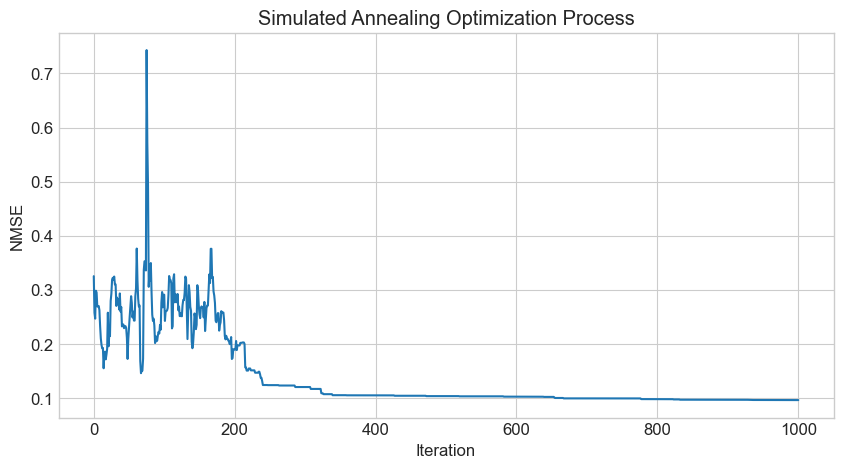

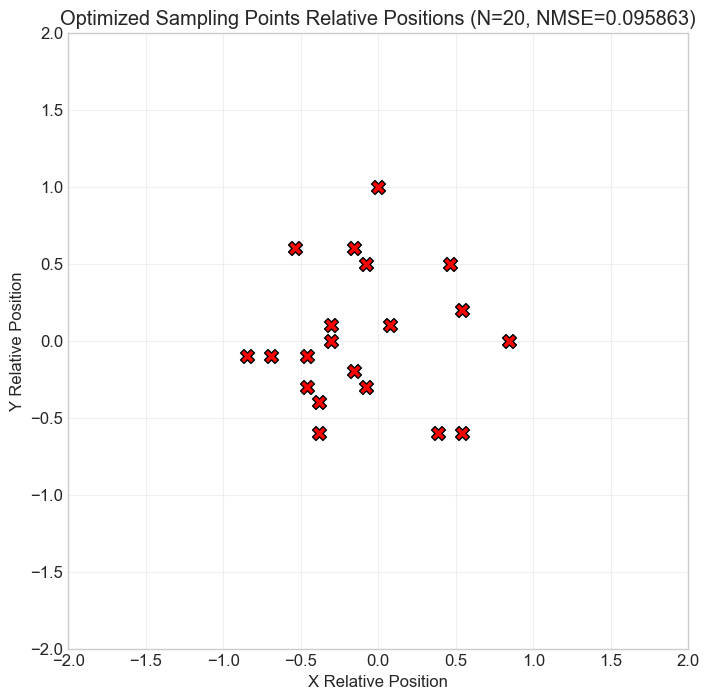

Optimized relative position coordinates:
Point 1: (0.846, 0.000)
Point 2: (-0.538, 0.600)
Point 3: (0.538, 0.200)
Point 4: (-0.154, 0.600)
Point 5: (-0.462, -0.300)
Point 6: (0.385, -0.600)
Point 7: (0.000, 1.000)
Point 8: (-0.385, -0.400)
Point 9: (-0.385, -0.600)
Point 10: (0.538, -0.600)
Point 11: (-0.077, -0.300)
Point 12: (-0.077, 0.500)
Point 13: (-0.692, -0.100)
Point 14: (-0.462, -0.100)
Point 15: (0.462, 0.500)
Point 16: (-0.308, 0.000)
Point 17: (-0.846, -0.100)
Point 18: (-0.154, -0.200)
Point 19: (0.077, 0.100)
Point 20: (-0.308, 0.100)


In [5]:
## 5. Simulated Annealing Algorithm for Optimizing Sampling Point Locations

# Define the uniform number of sampling points
N_points = 20

# Define the objective function: Calculate the predicted NMSE based on selected sampling points
def objective_function(indices, plate_data):
    """
    Calculates the predicted NMSE based on the specified sampling points.
    
    Args:
        indices: Array of sampling point indices.
        plate_data: Plate data.
        
    Returns:
        NMSE value (lower is better).
    """
    # Extract the coordinates and values of the selected points
    X_selected = plate_data['points'][indices]
    y_selected = plate_data['value_normalized'][indices]
    
    # Train the GPR model
    kernel = 1.0 * RBF(length_scale=40.0, length_scale_bounds=(1e-2, 1e3))
    model = GaussianProcessRegressor(
        kernel=kernel,
        alpha=1e-2,
        n_restarts_optimizer=5,
        random_state=123
    )
    
    try:
        model.fit(X_selected, y_selected)
        # Predict the entire field
        y_pred = model.predict(plate_data['points'])
        # Calculate NMSE
        nmse = mean_squared_error(plate_data['value_normalized'], y_pred) / np.var(plate_data['value_normalized'])
        return nmse
    except Exception as e:
        print(f"Model training failed: {e}")
        return np.inf

# Implement the simulated annealing algorithm to optimize sampling point locations
def simulated_annealing_optimization(plate_data, n_points=20, max_iter=1000, 
                                    initial_temp=100, cooling_rate=0.95, 
                                    n_neighbors=3):
    """
    Optimizes sampling point locations using the simulated annealing algorithm.
    
    Args:
        plate_data: Plate data.
        n_points: Number of sampling points.
        max_iter: Maximum number of iterations.
        initial_temp: Initial temperature.
        cooling_rate: Cooling rate.
        n_neighbors: Neighborhood range (number of points to replace each time).
        
    Returns:
        Array of the best sampling point indices.
    """
    print(f"Starting simulated annealing optimization for {n_points} sampling point locations...")
    
    # Get the total number of data points
    n_total_points = len(plate_data['points'])
    
    # Randomly initialize sampling point indices
    current_solution = np.random.choice(n_total_points, size=n_points, replace=False)
    current_energy = objective_function(current_solution, plate_data)
    
    # Initialize the best solution
    best_solution = current_solution.copy()
    best_energy = current_energy
    
    # Initialize temperature
    temp = initial_temp
    
    # Record energy history for visualization
    energy_history = [current_energy]
    
    # Start the simulated annealing iteration
    for i in range(max_iter):
        # Create a new candidate solution
        candidate_solution = current_solution.copy()
        
        # Randomly replace 1-n_neighbors points
        n_replace = np.random.randint(1, n_neighbors+1)
        indices_to_replace = np.random.choice(n_points, size=n_replace, replace=False)
        
        # Select points not in the current solution for replacement
        available_indices = np.setdiff1d(np.arange(n_total_points), current_solution)
        
        if len(available_indices) >= n_replace:
            new_indices = np.random.choice(available_indices, size=n_replace, replace=False)
            candidate_solution[indices_to_replace] = new_indices
            
            # Calculate the energy of the new solution
            candidate_energy = objective_function(candidate_solution, plate_data)
            
            # Calculate the energy difference
            delta_e = candidate_energy - current_energy
            
            # Metropolis criterion: Accept better solutions or accept worse solutions with a certain probability
            if delta_e < 0 or np.random.random() < np.exp(-delta_e / temp):
                current_solution = candidate_solution
                current_energy = candidate_energy
                
                # Update the best solution
                if current_energy < best_energy:
                    best_solution = current_solution.copy()
                    best_energy = current_energy
                    print(f"Iteration {i+1}/{max_iter}: Found a better solution, NMSE = {best_energy:.6f}")
        
        # Record current energy
        energy_history.append(current_energy)
        
        # Reduce temperature
        temp = temp * cooling_rate
        
        # Output progress every 100 iterations
        if (i+1) % 100 == 0:
            print(f"Iteration {i+1}/{max_iter}: Current temperature = {temp:.2f}, Current NMSE = {current_energy:.6f}, Best NMSE = {best_energy:.6f}")
    
    print(f"Optimization complete: Best NMSE = {best_energy:.6f}")
    
    # Visualize the optimization process
    plt.figure(figsize=(10, 5))
    plt.plot(energy_history)
    plt.title('Simulated Annealing Optimization Process')
    plt.xlabel('Iteration')
    plt.ylabel('NMSE')
    plt.grid(True)
    plt.savefig(os.path.join(results_dir, 'sa_optimization_process.png'), dpi=300)
    plt.show()
    
    return best_solution, best_energy

# Use the simulated annealing algorithm to optimize sampling points on the reference plate
reference_plate_name = 'sp-3'
reference_plate = plates_data[reference_plate_name]

# Run simulated annealing optimization
best_indices, best_nmse = simulated_annealing_optimization(
    reference_plate, 
    n_points=N_points,
    max_iter=1000,  # Can be adjusted as needed
    initial_temp=500.0,
    cooling_rate=0.95,
    n_neighbors=2
)

# Get the coordinates of the optimal sampling points
best_points = reference_plate['points'][best_indices]

# Convert the best sampling point coordinates to relative positions
def convert_to_relative_position(plate_data, points):
    """Convert absolute coordinates to relative coordinates (in the range 0-1).
    """
    # Get the coordinate extremes of the plate
    x_min, x_max = np.min(plate_data['x']), np.max(plate_data['x'])
    y_min, y_max = np.min(plate_data['y']), np.max(plate_data['y'])
    
    # Calculate the maximum absolute coordinate value for normalization
    x_abs_max = max(abs(x_min), abs(x_max))
    y_abs_max = max(abs(y_min), abs(y_max))
    
    # Normalize coordinates, keeping the origin (0,0) unchanged
    x_relative = points[:, 0] / x_abs_max if x_abs_max != 0 else points[:, 0]
    y_relative = points[:, 1] / y_abs_max if y_abs_max != 0 else points[:, 1]
    
    return np.column_stack((x_relative, y_relative))

# Convert the best sampling points to relative positions
relative_positions = convert_to_relative_position(reference_plate, best_points)

# Visualize the relative positions of the optimal sampling points
plt.figure(figsize=(8, 8))
plt.scatter(relative_positions[:, 0], relative_positions[:, 1], c='red', 
            s=100, marker='X', edgecolor='black')
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.grid(True, alpha=0.3)
plt.title(f'Optimized Sampling Points Relative Positions (N={N_points}, NMSE={best_nmse:.6f})')
plt.xlabel('X Relative Position')
plt.ylabel('Y Relative Position')
plt.savefig(os.path.join(results_dir, 'optimized_relative_positions.png'), dpi=300)
plt.show()

print("Optimized relative position coordinates:")
for i, pos in enumerate(relative_positions):
    print(f"Point {i+1}: ({pos[0]:.3f}, {pos[1]:.3f})")

## 6. Prediction Based on Unified Relative Positions

Using the unified relative positions of the sampling points, we will train and predict GPR models for each plate.

In [6]:
# Define a function to convert relative positions to absolute positions
def convert_to_absolute_position(plate_data, relative_positions):
    """Convert relative coordinates to absolute coordinates, keeping the origin (0,0) unchanged.
    
    Args:
        plate_data: Plate data dictionary.
        relative_positions: Array of relative position coordinates.
        
    Returns:
        Array of absolute position coordinates.
    """
    # Get the coordinate extremes of the plate
    x_min, x_max = np.min(plate_data['x']), np.max(plate_data['x'])
    y_min, y_max = np.min(plate_data['y']), np.max(plate_data['y'])
    
    # Calculate the maximum absolute coordinate value for denormalization
    x_abs_max = max(abs(x_min), abs(x_max))
    y_abs_max = max(abs(y_min), abs(y_max))
    
    # Convert relative coordinates back to absolute coordinates
    x_absolute = relative_positions[:, 0] * x_abs_max
    y_absolute = relative_positions[:, 1] * y_abs_max
    
    return np.column_stack((x_absolute, y_absolute))

# Define a function to find the indices of the nearest points
def find_nearest_point_indices(plate_data, target_positions):
    """Find the indices of the actual data points on the plate that are closest to the target positions.
    
    Args:
        plate_data: Plate data dictionary.
        target_positions: Array of target position coordinates.
        
    Returns:
        Array of indices of the closest actual data points.
    """
    # Get the coordinates of all data points
    all_points = plate_data['points']
    
    # Initialize the index array
    nearest_indices = []
    
    # For each target point, find the closest actual data point
    for target in target_positions:
        # Calculate the Euclidean distance from the target point to all data points
        distances = np.sqrt(np.sum((all_points - target)**2, axis=1))
        
        # Find the index of the point with the smallest distance
        nearest_idx = np.argmin(distances)
        nearest_indices.append(nearest_idx)
    
    return np.array(nearest_indices)


In [7]:
# Apply simulated annealing optimized relative positions to all plates and train models
optimized_results = {}

for plate_name, plate_data in plates_data.items():
    display_name = plate_name_mapping.get(plate_name, plate_name)
    print(f"\nApplying optimized sampling point locations to {display_name}...")
    
    # Convert relative positions to absolute positions on this plate
    absolute_positions = convert_to_absolute_position(plate_data, relative_positions)
    
    # Find the nearest actual data points
    optimized_indices = find_nearest_point_indices(plate_data, absolute_positions)
    
    # Ensure no duplicate points (if any, select alternative points)
    unique_indices = []
    used_indices = set()
    all_indices = set(range(len(plate_data['points'])))
    
    for idx in optimized_indices:
        if idx not in used_indices:
            unique_indices.append(idx)
            used_indices.add(idx)
        else:
            # If there are duplicates, select the nearest unused point
            available_indices = list(all_indices - used_indices)
            if available_indices:  # Make sure there are available points
                # Select the nearest unused point
                point = plate_data['points'][idx]
                distances = np.sqrt(np.sum((plate_data['points'][available_indices] - point)**2, axis=1))
                closest_available_idx = available_indices[np.argmin(distances)]
                unique_indices.append(closest_available_idx)
                used_indices.add(closest_available_idx)
    
    optimized_indices = np.array(unique_indices)
    
    # Get the coordinates and values of these points
    optimized_points = plate_data['points'][optimized_indices]
    optimized_values = plate_data['value_normalized'][optimized_indices]
    
    # Train the GPR model
    gpr_model = GPRModel()
    gpr_model.fit(optimized_points, optimized_values)
    
    # Predict the entire field
    y_pred_normalized = gpr_model.predict(plate_data['points'])
    y_pred = y_pred_normalized * (plate_data['value_max'] - plate_data['value_min']) + plate_data['value_min']
    
    # Calculate errors
    absolute_error = np.abs(plate_data['value'] - y_pred)
    relative_error = absolute_error / (plate_data['value_max'] - plate_data['value_min']) * 100
    nmse = mean_squared_error(plate_data['value_normalized'], y_pred_normalized) / np.var(plate_data['value_normalized'])
    
    # Save results
    optimized_results[display_name] = {
        'optimized_indices': optimized_indices,
        'optimized_points': optimized_points,
        'optimized_values': plate_data['value'][optimized_indices],
        'y_pred': y_pred,
        'y_pred_normalized': y_pred_normalized,
        'absolute_error': absolute_error,
        'relative_error': relative_error,
        'nmse': nmse,
        'gpr_model': gpr_model
    }
    
    print(f"  NMSE with optimized sampling points: {nmse:.6f}")
    print(f"  Absolute Error (Mean): {np.mean(absolute_error):.4f}")
    print(f"  Absolute Error (Max): {np.max(absolute_error):.4f}")
    print(f"  Relative Error (Mean): {np.mean(relative_error):.2f}%")
    
    # Save sampling point data to CSV
    sample_df = pd.DataFrame({
        'x': optimized_points[:, 0],
        'y': optimized_points[:, 1],
        'value': plate_data['value'][optimized_indices]
    })
    sample_df.to_csv(os.path.join(results_dir, f'{display_name}_optimized_points.csv'), index=False)


Applying optimized sampling point locations to Specimen-1...
  NMSE with optimized sampling points: 0.210371
  Absolute Error (Mean): 0.0232
  Absolute Error (Max): 0.1027
  Relative Error (Mean): 8.58%

Applying optimized sampling point locations to Specimen-2...
  NMSE with optimized sampling points: 0.269146
  Absolute Error (Mean): 0.0259
  Absolute Error (Max): 0.1255
  Relative Error (Mean): 10.56%

Applying optimized sampling point locations to Specimen-3...
  NMSE with optimized sampling points: 0.095863
  Absolute Error (Mean): 0.0161
  Absolute Error (Max): 0.0865
  Relative Error (Mean): 5.87%

Applying optimized sampling point locations to Specimen-4...
  NMSE with optimized sampling points: 0.275104
  Absolute Error (Mean): 0.0242
  Absolute Error (Max): 0.0912
  Relative Error (Mean): 8.80%


## 7. Performance Evaluation and NMSE Calculation

Normalized Mean Squared Error (NMSE) is a useful metric for evaluating the performance of prediction models, calculated as follows:

$$NMSE = \frac{MSE}{\sigma^2_y} = \frac{\frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}{\frac{1}{n}\sum_{i=1}^{n}(y_i - \bar{y})^2}$$

Where:
- $y_i$ is the true value
- $\hat{y}_i$ is the predicted value
- $\bar{y}$ is the mean of the true values
- $\sigma^2_y$ is the variance of the true values

NMSE Characteristics:
- NMSE = 0 indicates perfect prediction
- NMSE = 1 indicates performance equivalent to simple mean prediction
- NMSE > 1 indicates performance worse than predicting the mean


Performance Evaluation Results:
        Plate   NMSE  Mean Absolute Error  Max Absolute Error  \
0  Specimen-1 0.2104               0.0232              0.1027   
1  Specimen-2 0.2691               0.0259              0.1255   
2  Specimen-3 0.0959               0.0161              0.0865   
3  Specimen-4 0.2751               0.0242              0.0912   

   Mean Relative Error (%)  
0                   8.5797  
1                  10.5649  
2                   5.8669  
3                   8.8003  


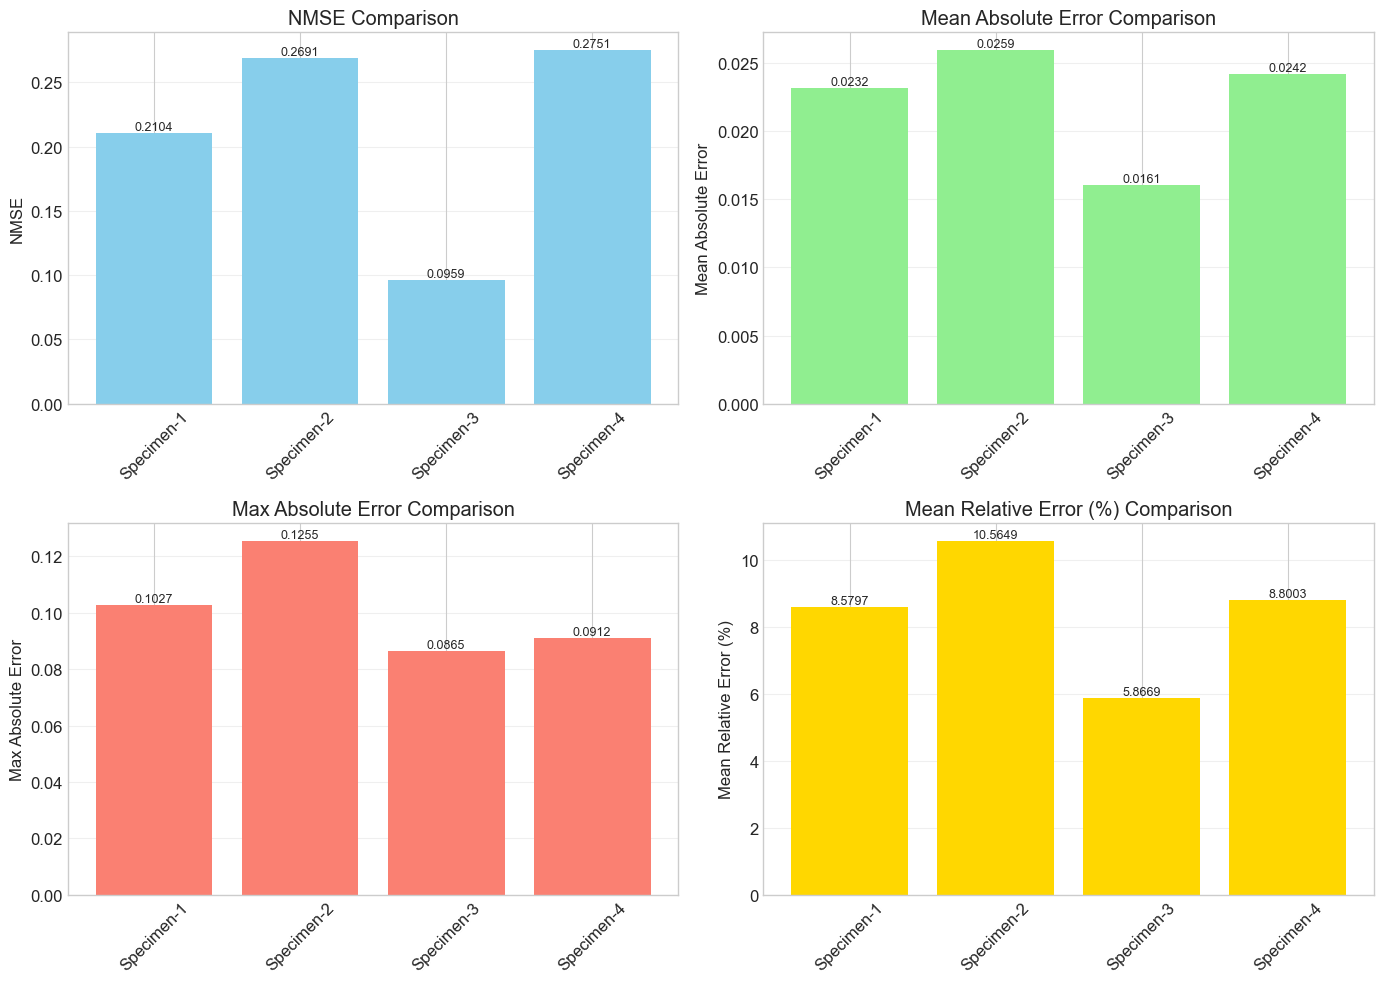

In [8]:
# Create performance evaluation table
performance_results = {
    'Plate': [],
    'NMSE': [],
    'Mean Absolute Error': [],
    'Max Absolute Error': [],
    'Mean Relative Error (%)': [],
}

for plate_name, result in optimized_results.items():
    display_name = plate_name_mapping.get(plate_name, plate_name) 
    performance_results['Plate'].append(plate_name)
    performance_results['NMSE'].append(result['nmse'])
    performance_results['Mean Absolute Error'].append(np.mean(result['absolute_error']))
    performance_results['Max Absolute Error'].append(np.max(result['absolute_error']))
    performance_results['Mean Relative Error (%)'].append(np.mean(result['relative_error']))


pd.set_option('display.float_format', '{:.4f}'.format)

# Create performance table
performance_df = pd.DataFrame(performance_results)
print("\nPerformance Evaluation Results:")
print(performance_df)

# Save results to CSV
performance_df.to_csv(os.path.join(results_dir, 'performance_metrics.csv'), index=False)

# Create performance metrics visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
metrics = ['NMSE', 'Mean Absolute Error', 'Max Absolute Error', 'Mean Relative Error (%)']
colors = ['skyblue', 'lightgreen', 'salmon', 'gold']

for i, (metric, color) in enumerate(zip(metrics, colors)):
    ax = axes.flatten()[i]
    ax.bar(performance_df['Plate'], performance_df[metric], color=color)
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylabel(metric)
    ax.set_title(f'{metric} Comparison')
    
    # Add value labels on each bar
    for j, value in enumerate(performance_df[metric]):
        ax.text(j, value, f'{value:.4f}' if metric == 'NMSE' else f'{value:.4f}',
                ha='center', va='bottom', fontsize=9)
    
    plt.setp(ax.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'performance_metrics_comparison.png'), dpi=300)
plt.show()

## 8. Results Visualization and Analysis

To fully understand the effectiveness of the unified sampling point method, we will create detailed visualizations, including a comparison of original and predicted distributions, error distribution plots, and the locations of the selected sampling points.


Generating visualizations for Specimen-1...


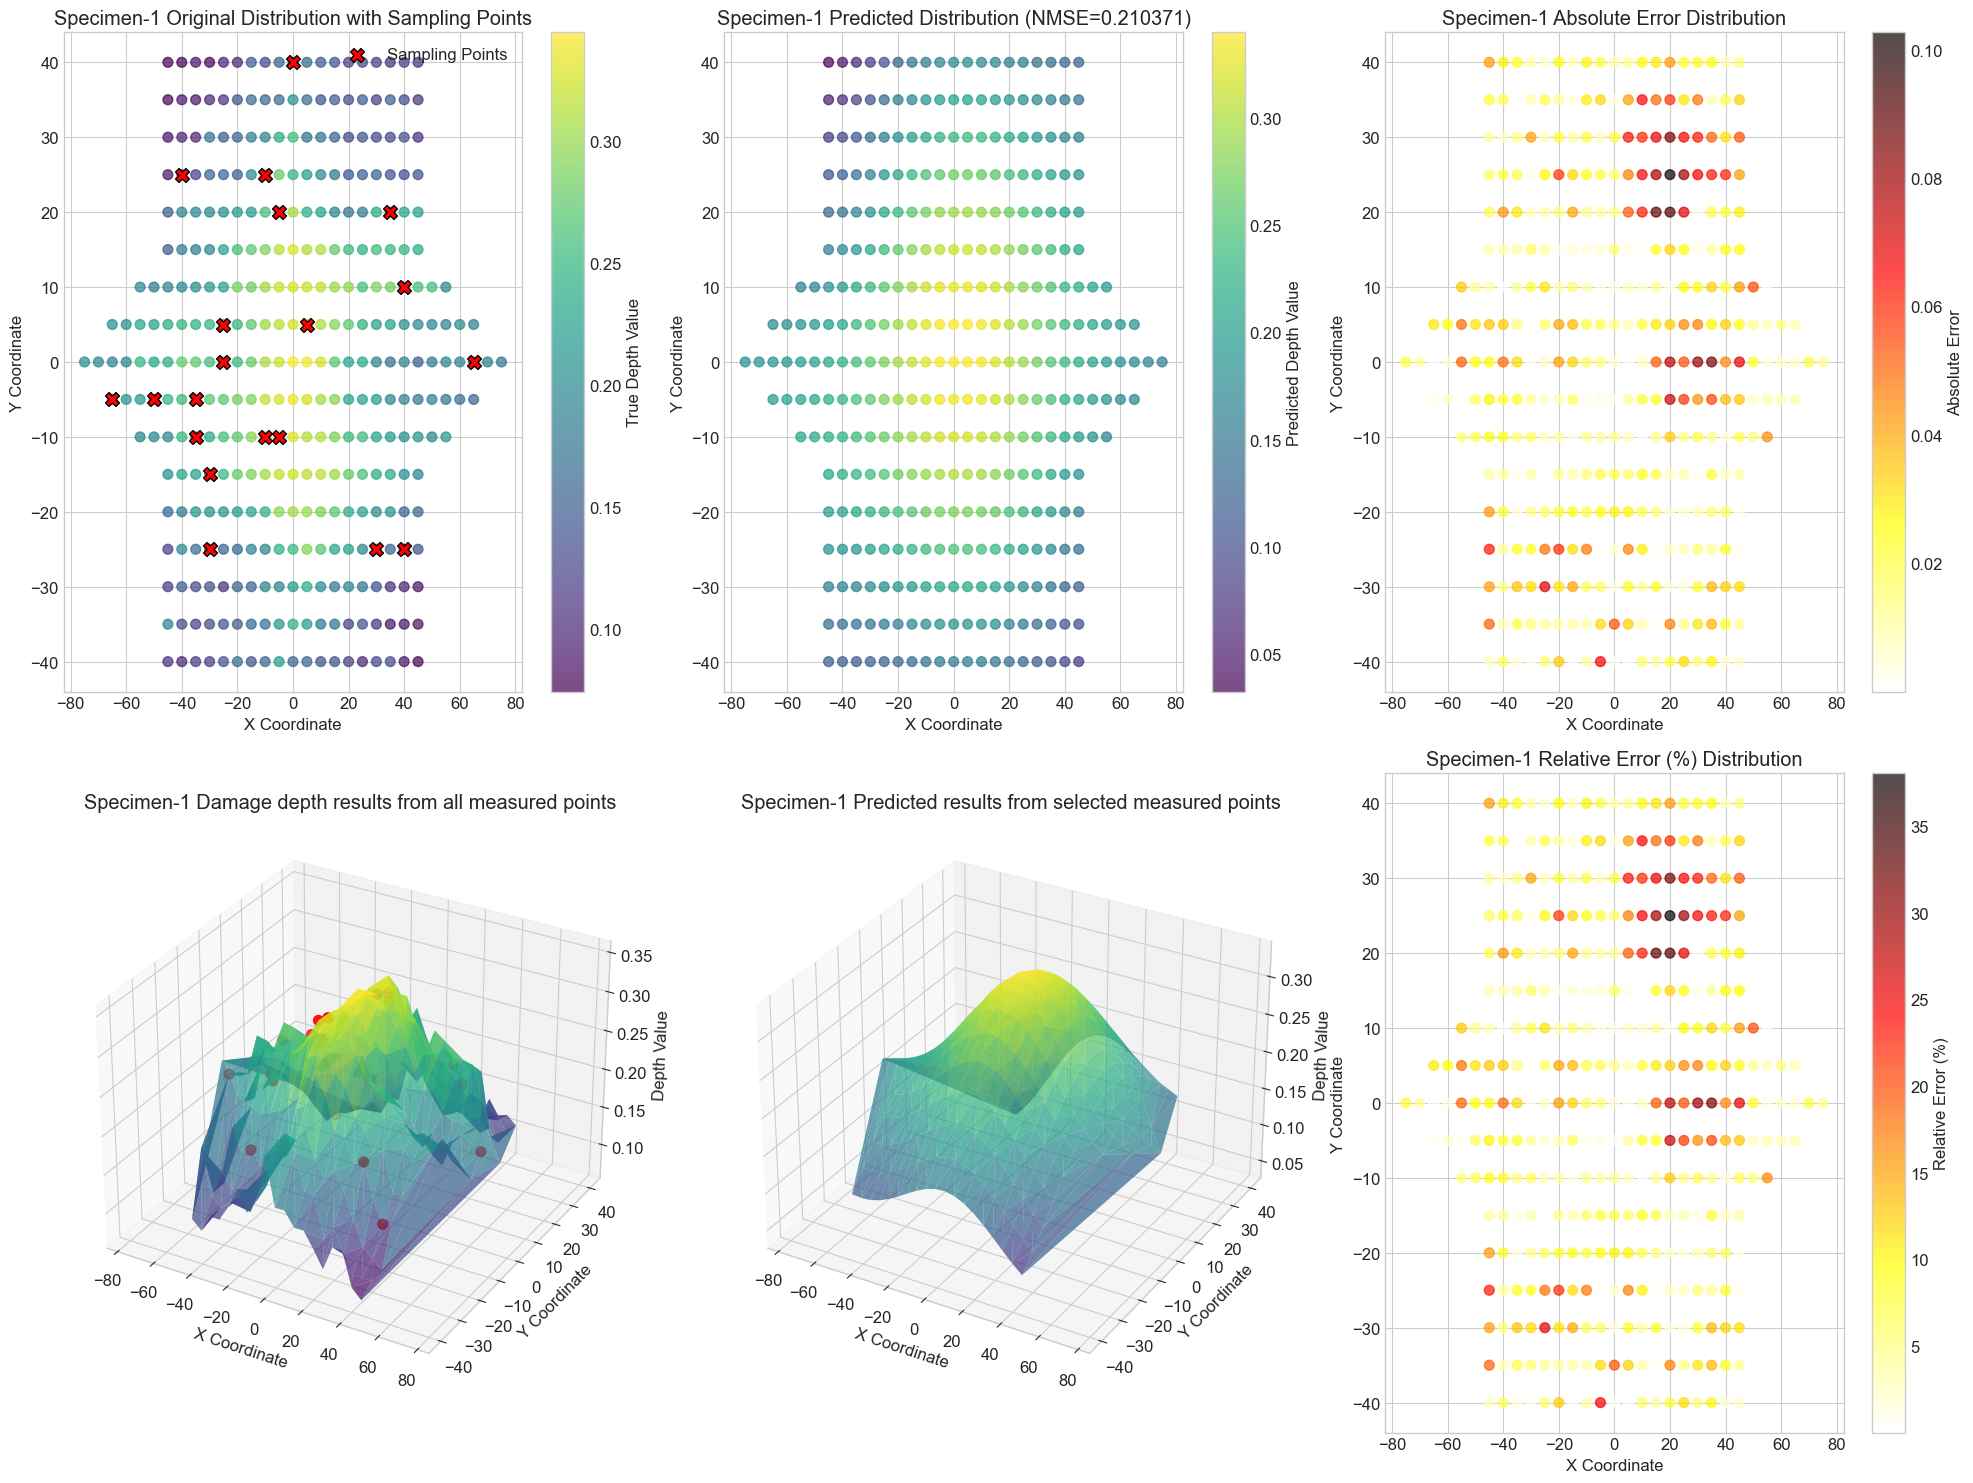

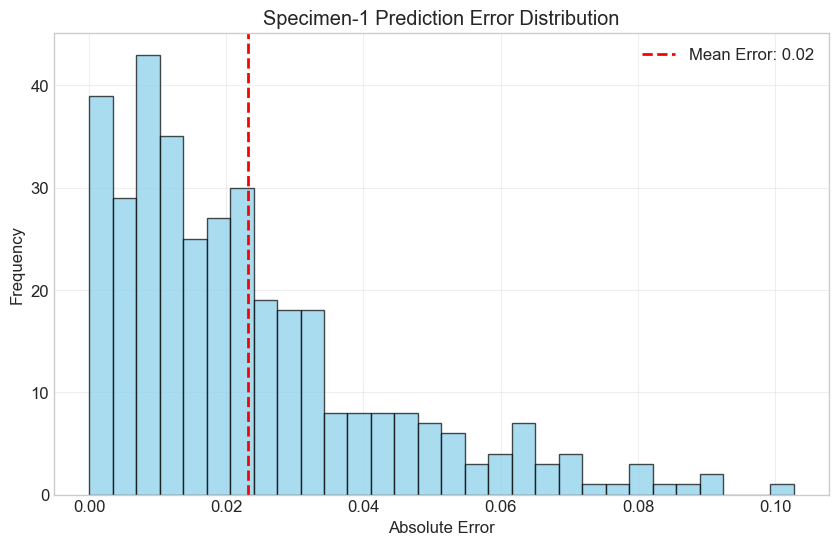


Error Statistics for Specimen-1:
                    Metric  Value
0                     NMSE 0.2104
1      Mean Absolute Error 0.0232
2       Max Absolute Error 0.1027
3  Mean Relative Error (%) 8.5797

Generating visualizations for Specimen-2...


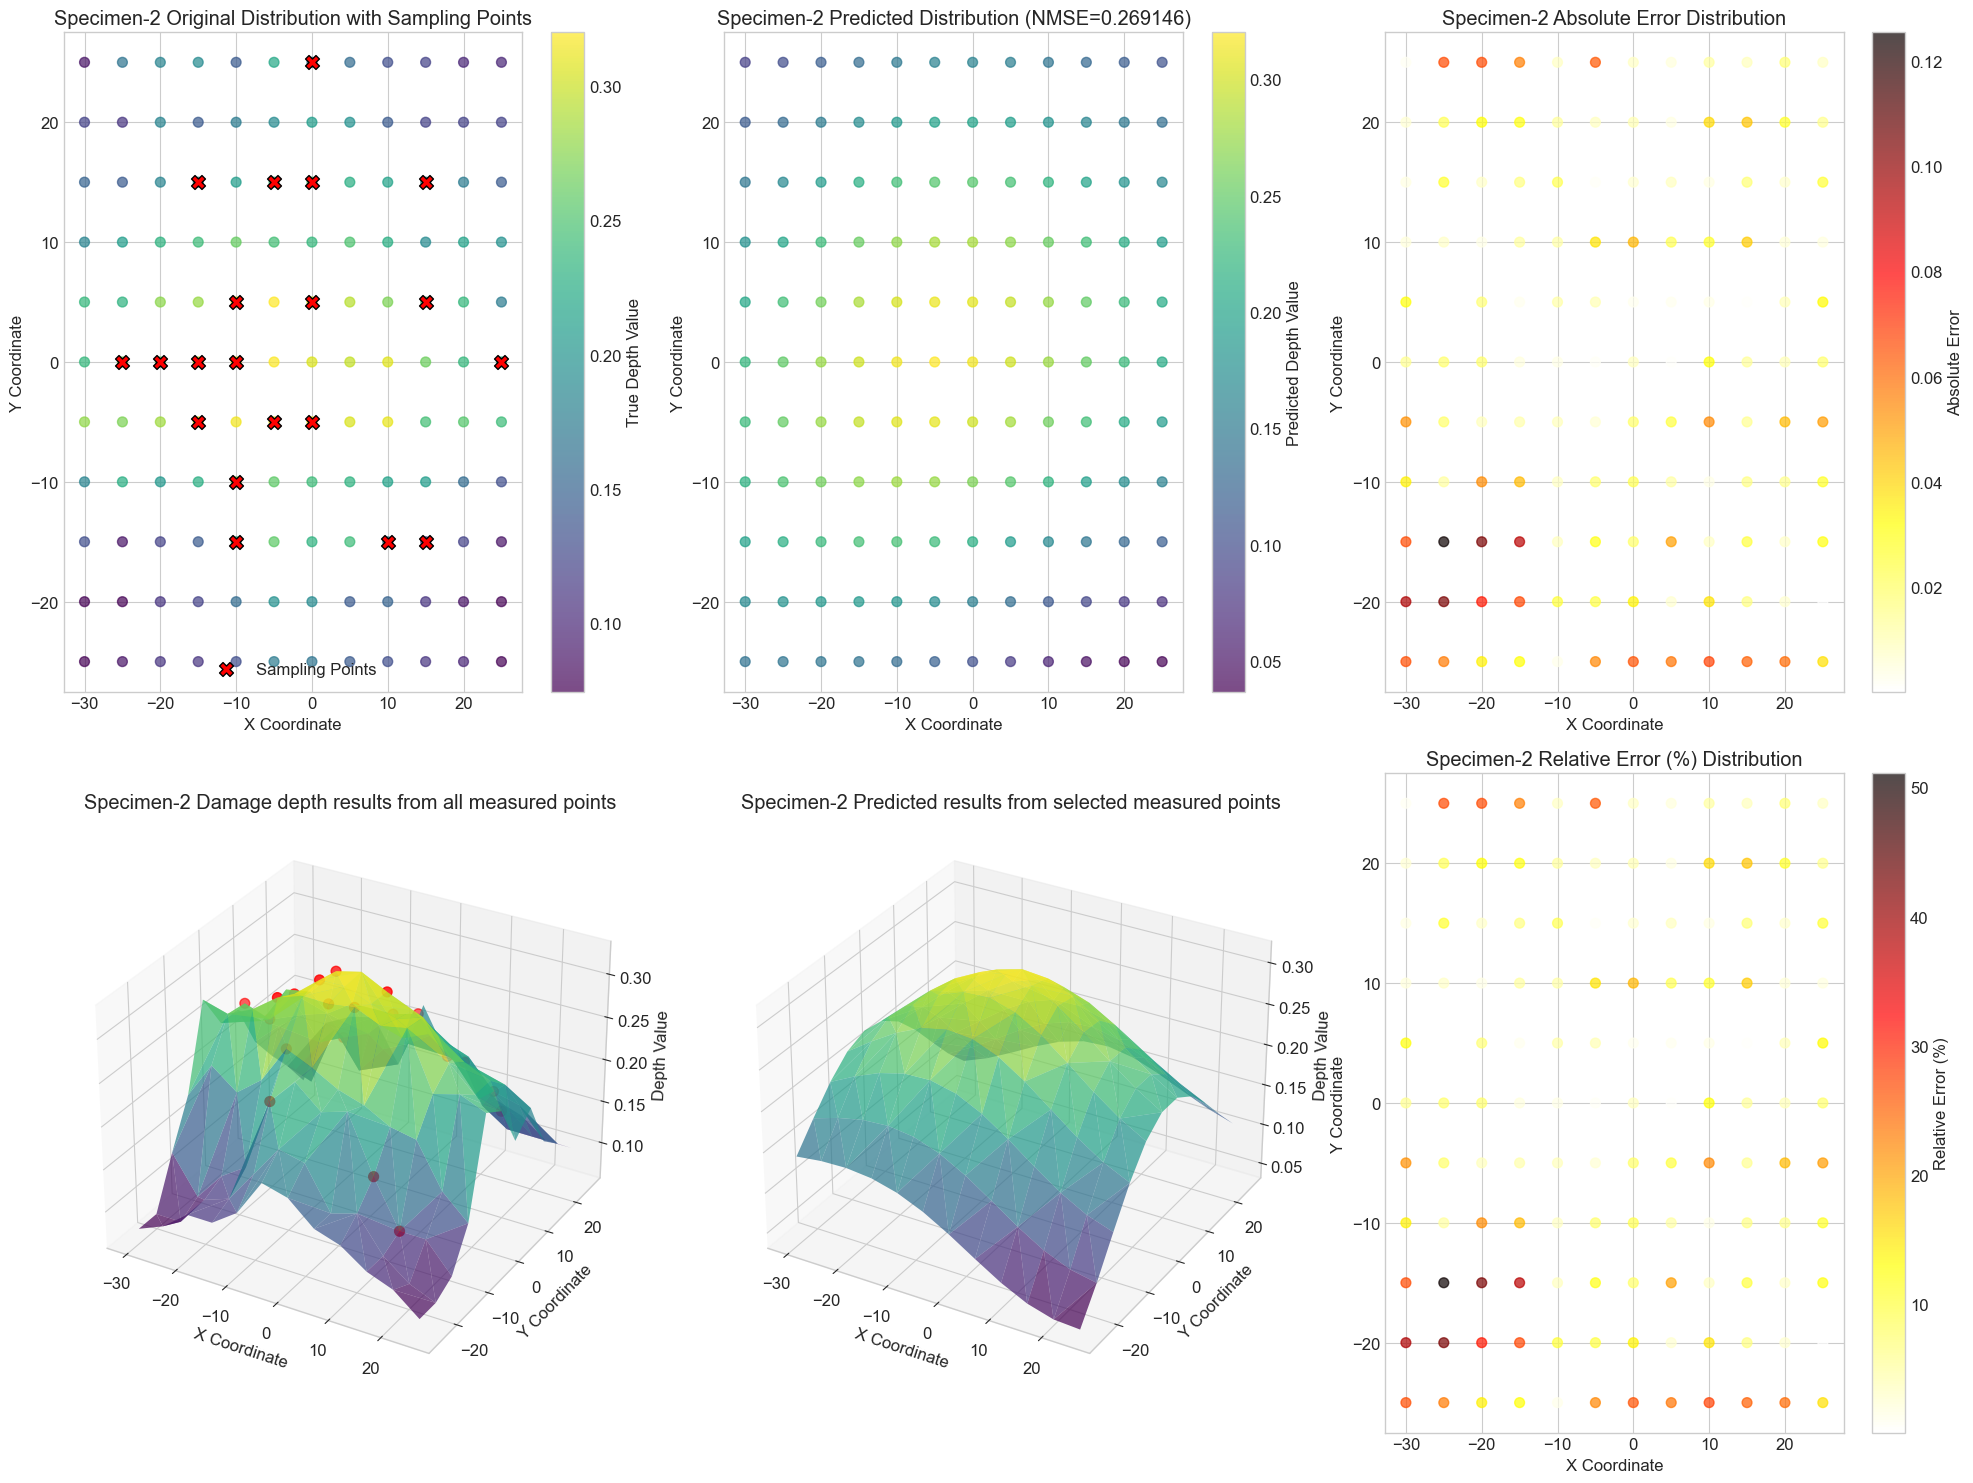

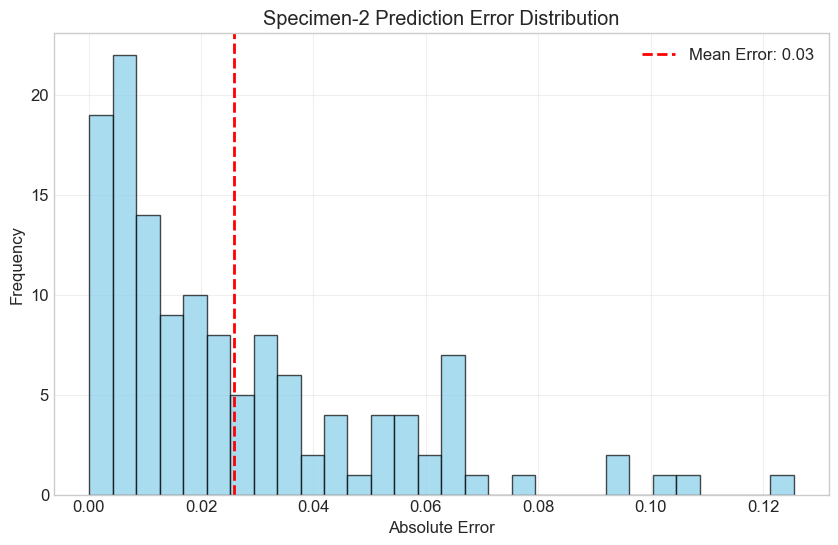


Error Statistics for Specimen-2:
                    Metric   Value
0                     NMSE  0.2691
1      Mean Absolute Error  0.0259
2       Max Absolute Error  0.1255
3  Mean Relative Error (%) 10.5649

Generating visualizations for Specimen-3...


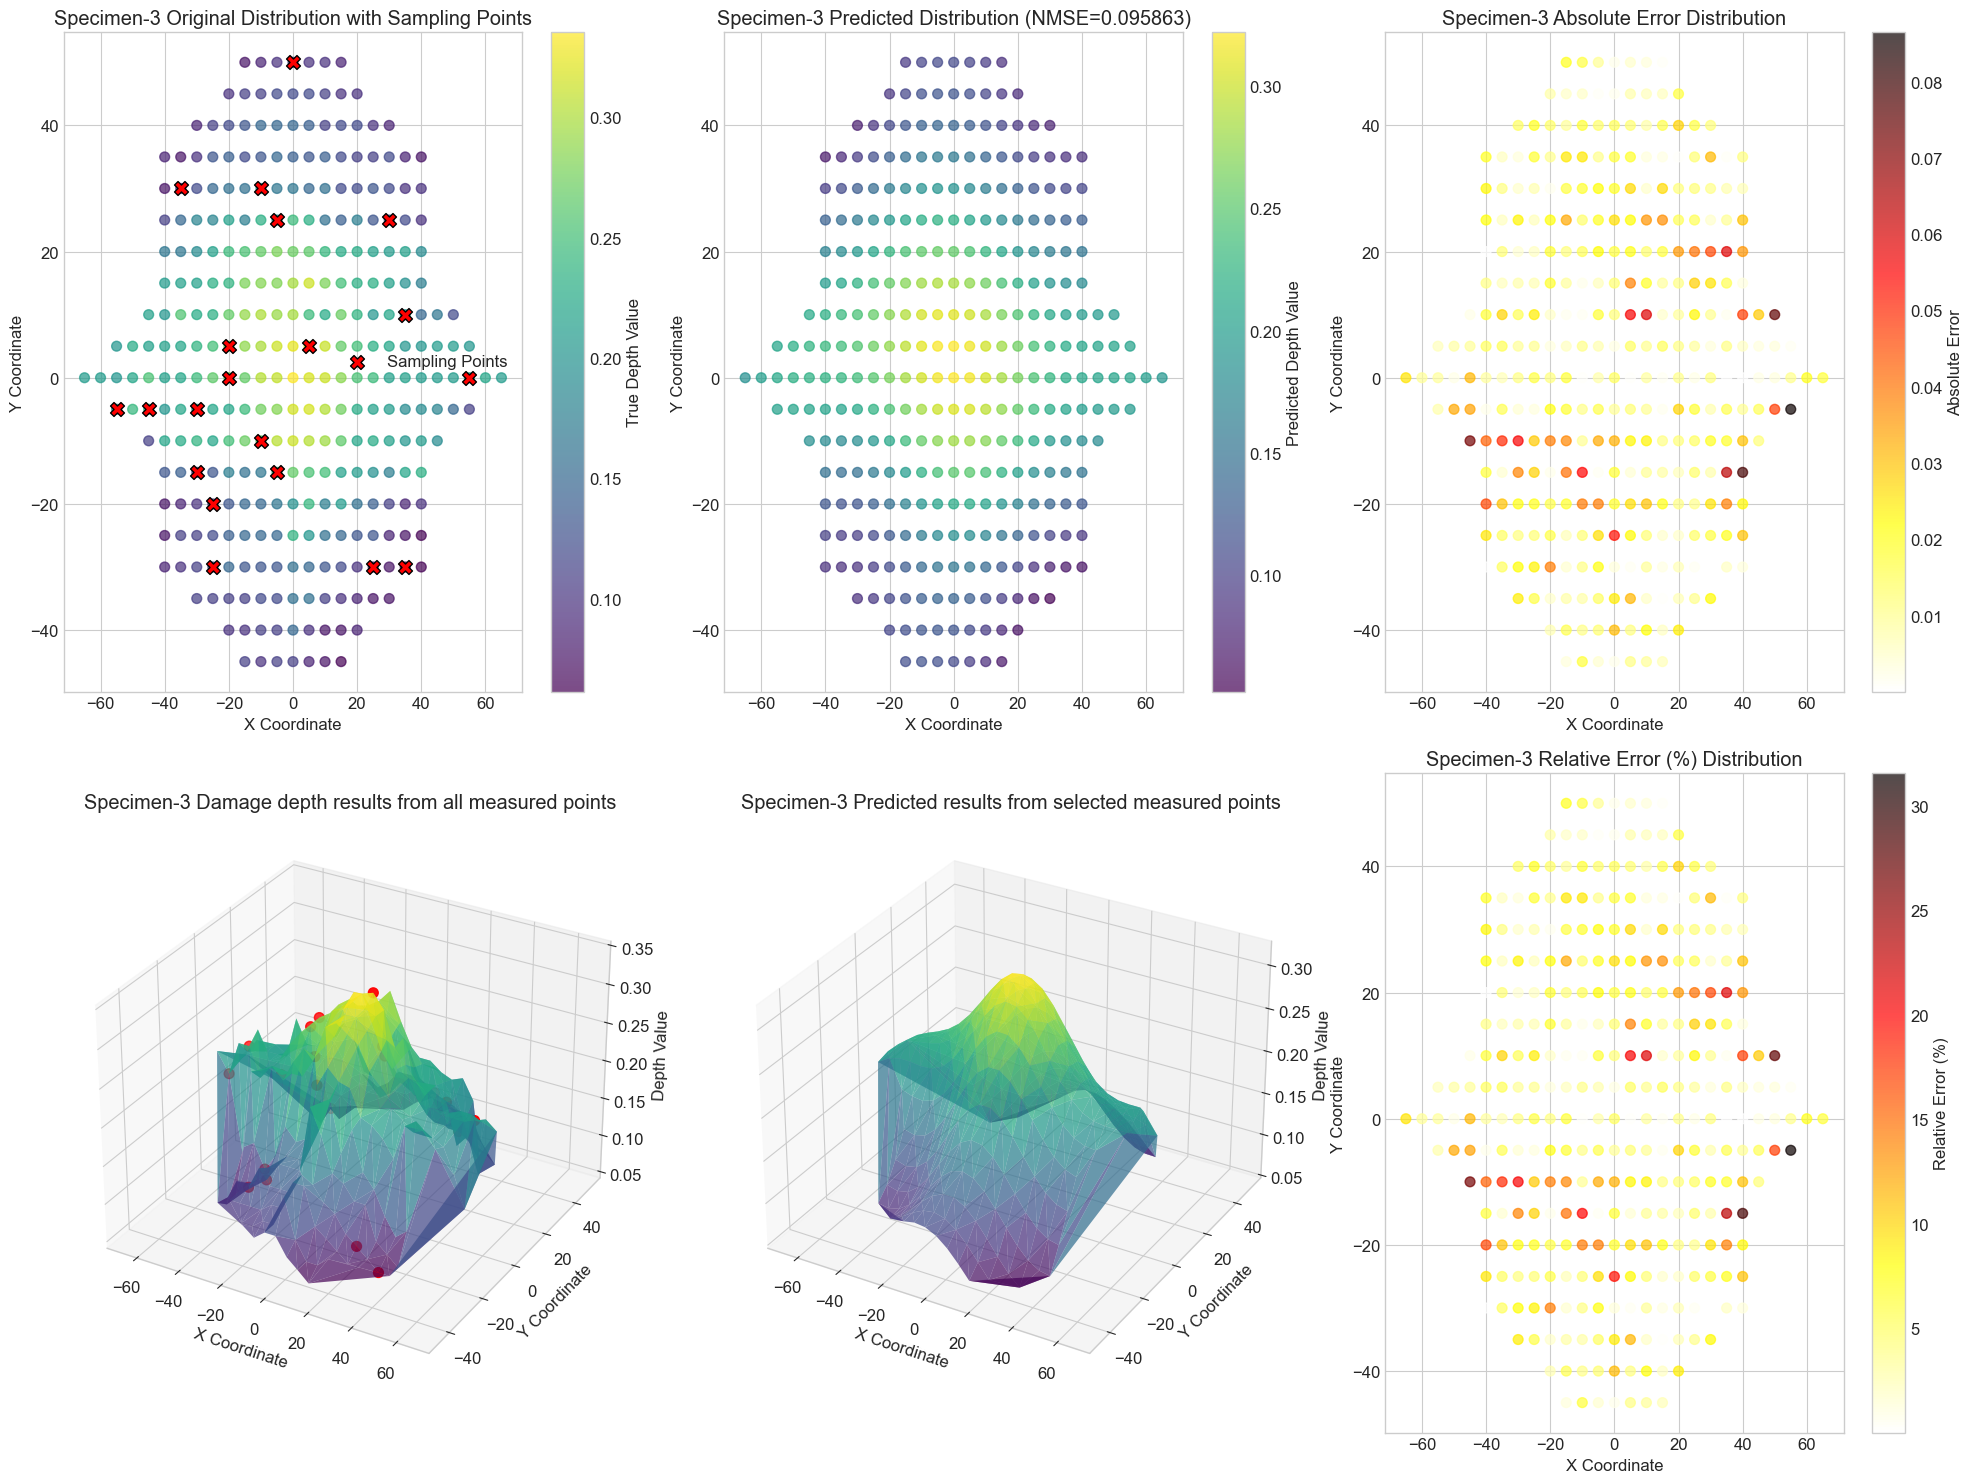

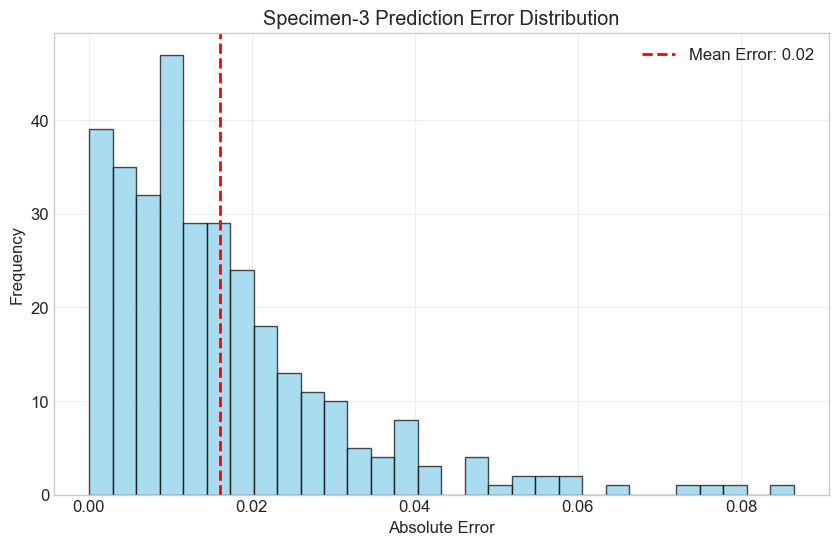


Error Statistics for Specimen-3:
                    Metric  Value
0                     NMSE 0.0959
1      Mean Absolute Error 0.0161
2       Max Absolute Error 0.0865
3  Mean Relative Error (%) 5.8669

Generating visualizations for Specimen-4...


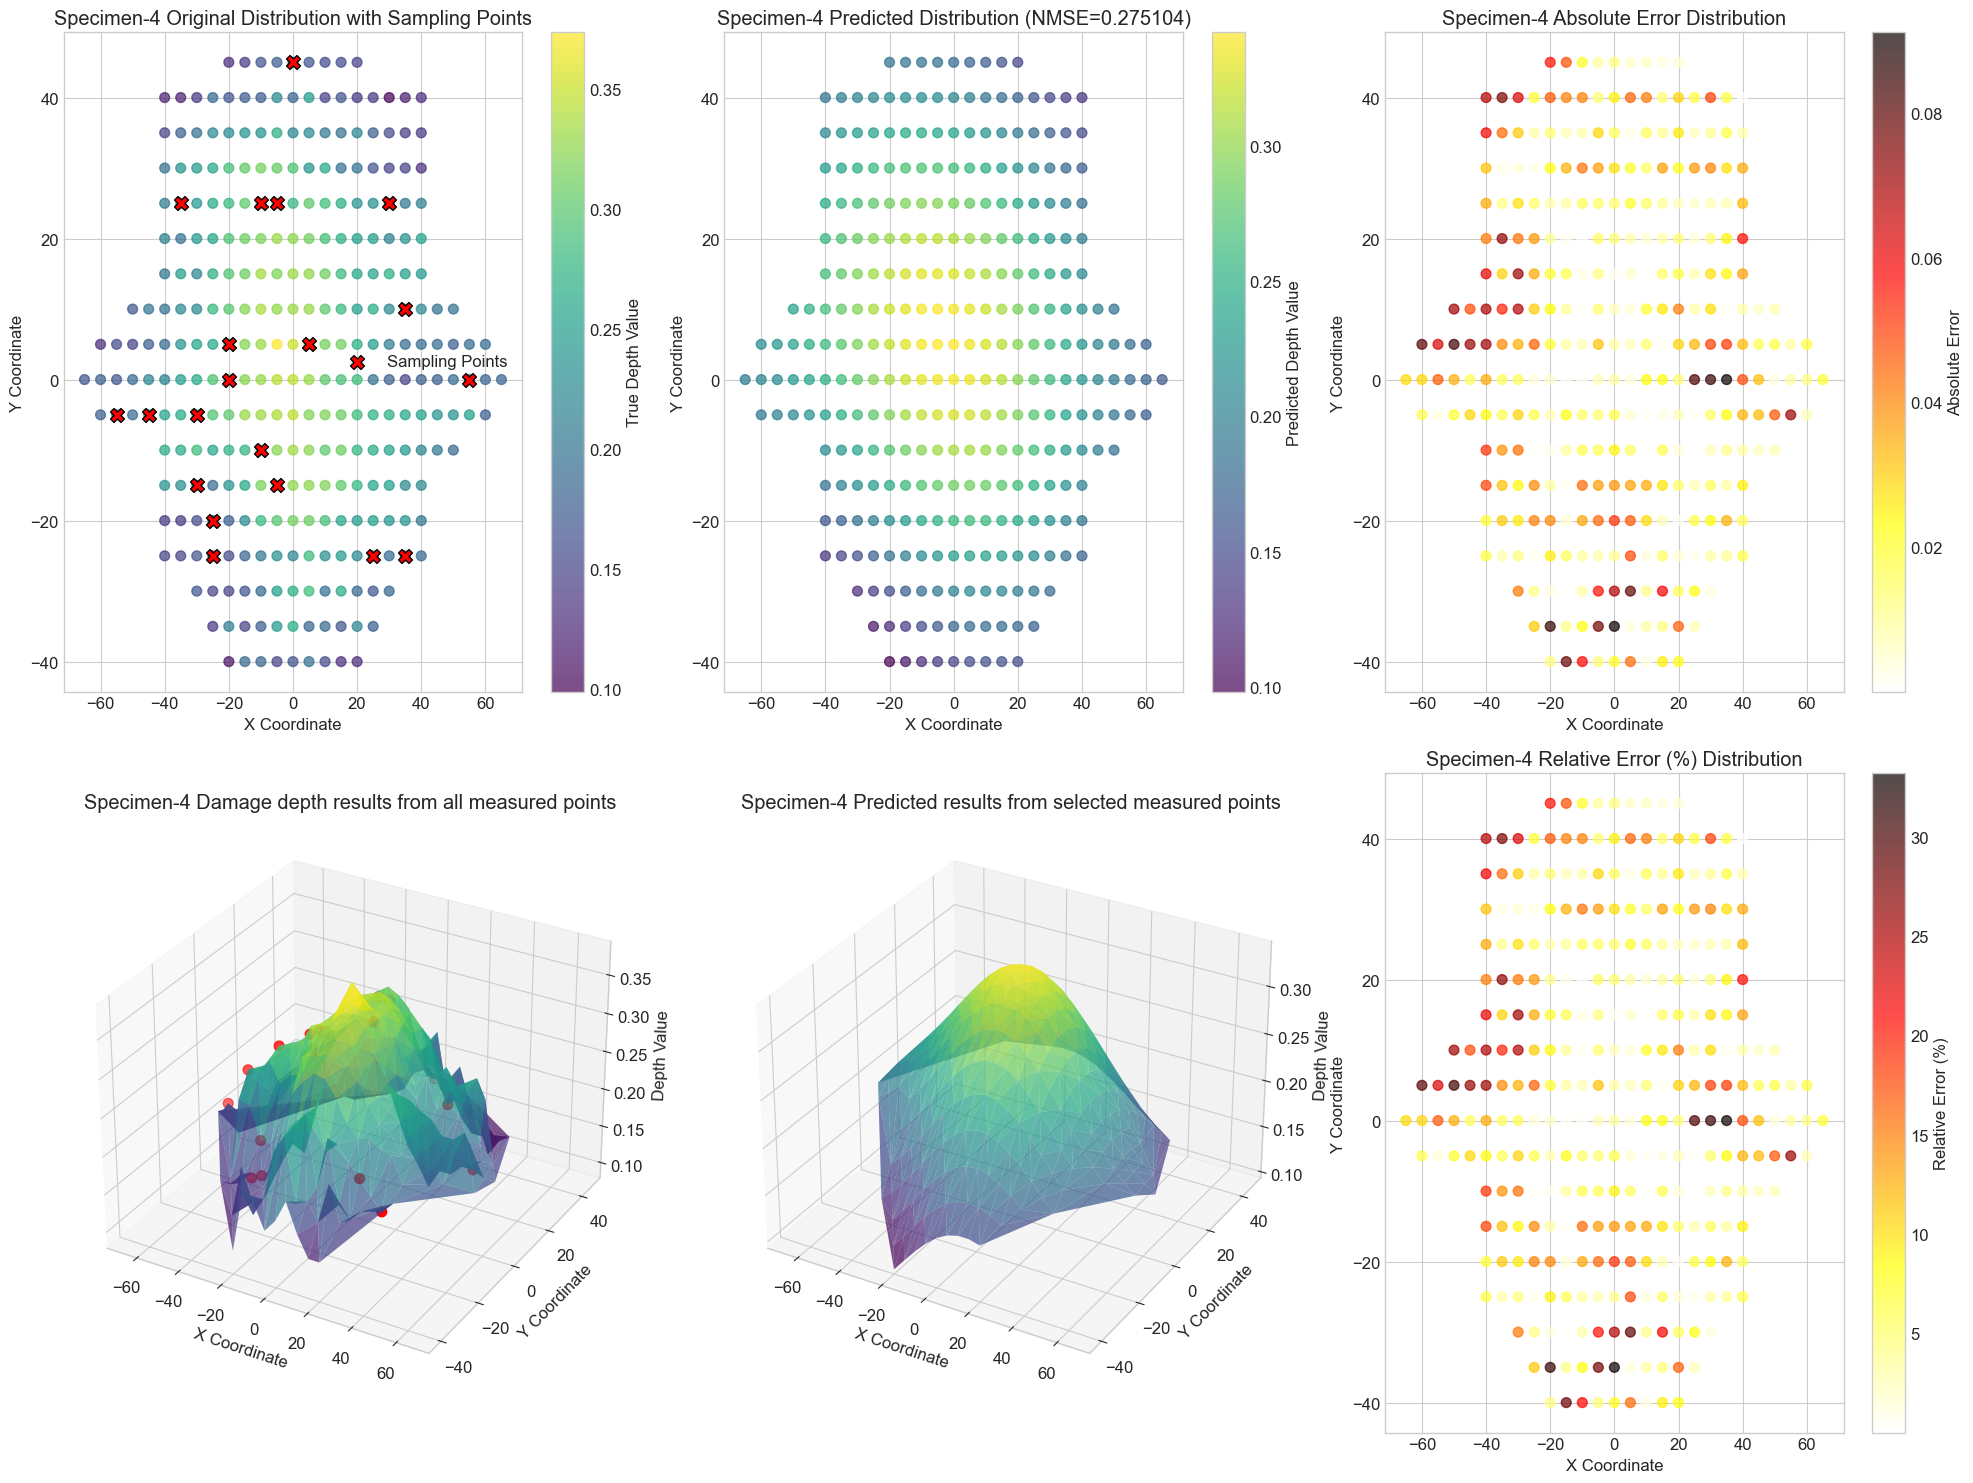

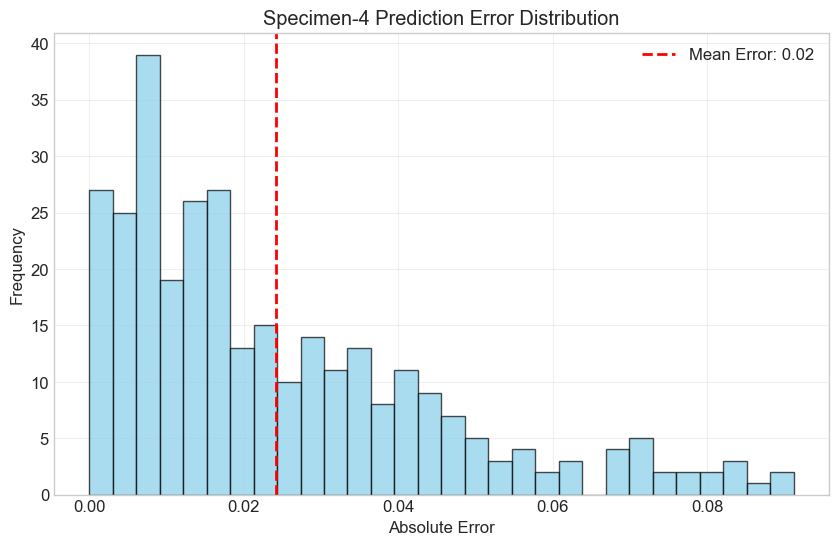


Error Statistics for Specimen-4:
                    Metric  Value
0                     NMSE 0.2751
1      Mean Absolute Error 0.0242
2       Max Absolute Error 0.0912
3  Mean Relative Error (%) 8.8003


In [9]:
# Create comprehensive visualizations for each plate's prediction results
def visualize_prediction_results(plate_name, plate_data, result, results_dir):
    """
    Create detailed visualizations of GPR prediction results
    
    Parameters:
        plate_name: Name of the plate
        plate_data: Original plate data dictionary
        result: Prediction result dictionary
        results_dir: Directory to save results
    """
    display_name = plate_name_mapping.get(plate_name, plate_name)

    # Extract needed data
    x = plate_data['x']
    y = plate_data['y']
    z_true = plate_data['value']
    z_pred = result['y_pred']
    error = result['absolute_error']
    rel_error = result['relative_error']
    sampling_points = result['optimized_points']
    sampling_values = result['optimized_values']
    nmse = result['nmse']
    
    # Create figure with multiple subplots for comprehensive visualization
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Original Distribution (2D Color Map)
    ax1 = fig.add_subplot(231)
    scatter1 = ax1.scatter(x, y, c=z_true, cmap='viridis', s=50, alpha=0.7)
    ax1.scatter(sampling_points[:, 0], sampling_points[:, 1], c='red', s=100, marker='X', edgecolor='black', label='Sampling Points')
    ax1.set_title(f'{display_name} Original Distribution with Sampling Points')
    ax1.set_xlabel('X Coordinate')
    ax1.set_ylabel('Y Coordinate')
    ax1.legend()
    plt.colorbar(scatter1, ax=ax1, label='True Depth Value')
    
    # 2. Predicted Distribution (2D Color Map)
    ax2 = fig.add_subplot(232)
    scatter2 = ax2.scatter(x, y, c=z_pred, cmap='viridis', s=50, alpha=0.7)
    ax2.set_title(f'{display_name} Predicted Distribution (NMSE={nmse:.6f})')
    ax2.set_xlabel('X Coordinate')
    ax2.set_ylabel('Y Coordinate')
    plt.colorbar(scatter2, ax=ax2, label='Predicted Depth Value')
    
    # 3. Absolute Error Distribution
    ax3 = fig.add_subplot(233)
    scatter3 = ax3.scatter(x, y, c=error, cmap='hot_r', s=50, alpha=0.7)
    ax3.set_title(f'{display_name} Absolute Error Distribution')
    ax3.set_xlabel('X Coordinate')
    ax3.set_ylabel('Y Coordinate')
    plt.colorbar(scatter3, ax=ax3, label='Absolute Error')
    
    # 4. 3D Surface Plot - Original
    ax4 = fig.add_subplot(234, projection='3d')
    surf1 = ax4.plot_trisurf(x, y, z_true, cmap='viridis', edgecolor='none', alpha=0.7)
    ax4.scatter(sampling_points[:, 0], sampling_points[:, 1], sampling_values, 
                c='red', s=50, marker='o', label='Sampling Points')
    ax4.set_title(f'{display_name} Damage depth results from all measured points')
    ax4.set_xlabel('X Coordinate')
    ax4.set_ylabel('Y Coordinate')
    ax4.set_zlabel('Depth Value')
    
    # 5. 3D Surface Plot - Predicted
    ax5 = fig.add_subplot(235, projection='3d')
    surf2 = ax5.plot_trisurf(x, y, z_pred, cmap='viridis', edgecolor='none', alpha=0.7)
    ax5.set_title(f'{display_name} Predicted results from selected measured points')
    ax5.set_xlabel('X Coordinate')
    ax5.set_ylabel('Y Coordinate')
    ax5.set_zlabel('Depth Value')
    
    # 6. Relative Error Distribution or Histogram
    ax6 = fig.add_subplot(236)
    scatter6 = ax6.scatter(x, y, c=rel_error, cmap='hot_r', s=50, alpha=0.7)
    ax6.set_title(f'{display_name} Relative Error (%) Distribution')
    ax6.set_xlabel('X Coordinate')
    ax6.set_ylabel('Y Coordinate')
    plt.colorbar(scatter6, ax=ax6, label='Relative Error (%)')
    
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, f'{display_name}_prediction_results.png'), dpi=300)
    plt.show()
    
    # Additional visualization: Error histogram
    plt.figure(figsize=(10, 6))
    plt.hist(error, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    plt.axvline(np.mean(error), color='r', linestyle='--', linewidth=2, 
                label=f'Mean Error: {np.mean(error):.2f}')
    plt.xlabel('Absolute Error')
    plt.ylabel('Frequency')
    plt.title(f'{display_name} Prediction Error Distribution')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.savefig(os.path.join(results_dir, f'{display_name}_error_histogram.png'), dpi=300)
    plt.show()

    # Create a table of error statistics
    error_stats = pd.DataFrame({
        'Metric': ['NMSE', 'Mean Absolute Error', 'Max Absolute Error', 
                  'Mean Relative Error (%)'],
        'Value': [nmse, np.mean(error), np.max(error), 
                 np.mean(rel_error)]
    })
    
    # Print error statistics
    print(f"\nError Statistics for {display_name}:")
    print(error_stats)
    
    # Save error statistics to CSV
    error_stats.to_csv(os.path.join(results_dir, f'{display_name}_error_stats.csv'), index=False)

# Create reverse mapping from display names to original plate names
reverse_plate_mapping = {display: original for original, display in plate_name_mapping.items()}

# Create visualizations for each plate
for plate_name, result in optimized_results.items():
    # Check if the plate_name is a display name and get the original name if it is
    original_plate_name = reverse_plate_mapping.get(plate_name, plate_name)
    display_name = plate_name_mapping.get(original_plate_name, plate_name)
    
    print(f"\nGenerating visualizations for {display_name}...")
    visualize_prediction_results(original_plate_name, plates_data[original_plate_name], result, results_dir)


This study demonstrates that using 20 sampling points with unified relative positions can achieve reasonable hardness distribution predictions, providing a viable alternative to actual measurements. The rationale is as follows:

1.  **Simplified Measurement Process**: The same measurement template can be used to sample all plates, reducing complexity during the measurement process.
2.  **Standardized Method**: Provides a standardized prediction method for different plates, facilitating implementation and management.
3.  **Broad Applicability**: Performs well when plates have similar distribution characteristics.